## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

## Reading the data from the data source

In [2]:
df_dict = pd.read_excel('https://cdn.upgrad.com/UpGrad/temp/af860da6-f838-47d6-ad97-551022550ee4/Data_Dictionary.xlsx')

In [3]:
rows = df_dict.head().loc[0,'Description']

In [4]:
df_loan = pd.read_csv('loan.csv')

df_loan.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(39717, 111)

In [5]:
ser_cols = df_loan.isnull().sum()


## Droping the unwanted columns

##### The columns that have more than 90% of null values are dropped

In [6]:
max_nulls = int(df_loan.shape[0]*0.9)
for column in ser_cols.index:
    if(df_loan[column].isnull().sum() > max_nulls):
        df_loan.drop([column], inplace = True, axis= 'columns')

In [7]:
df_loan.to_csv("Test.csv")

In [10]:
df_loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

# Lets clean the years of employment and refine the data type to int or a float

In [11]:

df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: str(x))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: x.replace('years',""))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: x.replace('year',""))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: x.replace('+',""))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: x.replace(' ',""))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: x.replace('<',""))
df_loan['emp_length'] = df_loan['emp_length'].apply(lambda x: float(x))
mrv =  df_loan['emp_length'].median()
df_loan[df_loan['emp_length'] >= mrv]['loan_status'].value_counts()

Fully Paid     18382
Charged Off     3182
Current          772
Name: loan_status, dtype: int64

## Lets Clean the Intrest Rate column from the data set

<h3>The column is string we have to change it to float i.e <u>Numeric</u></h3>

In [12]:
df_loan["int_rate"] = df_loan['int_rate'].apply(lambda p: p.replace('%',''))
df_loan["int_rate"] = df_loan['int_rate'].apply(lambda p: float(p))

In [13]:
df_loan['RevolBalToAnnualInc'] = df_loan['revol_bal']/df_loan['annual_inc']

In [14]:
df_loan['revol_bal'].median()

8850.0

## Lets filter out the non defaulters.

### The data set will only have charged off people as we want to examine the behavior of defaulters

#### We have 2 sets of data one containing defaulters and other set has no defaulters

In [15]:
df_loan_defaulters =  df_loan[df_loan["loan_status"] == "Charged Off"]
df_loan_non_defaulters = df_loan[~(df_loan["loan_status"] == "Charged Off")]

## Lets Do Univariate and segmented univariate analysis
<ul>
    <li> Lets cut the data in the form of buckets</li>
    <li> We will use pd.cut function available</li>
</ul>

## We will divide columns into buckets

### We will plot the percentage of defaulters based on the buckets

### If the percentage defaulters is higher in the bucket more riskier the bucket is. 

In [16]:
df_loan['loan_amnt'].max()

35000

### We Define function that generates the following

<ol>
    <li>Generate interval in friendly format i.e float values It contains lower limit and upperlimit of bucket</li>
    <li>We calculate the percentage of defaulters(charged off) in the buckets </li>
    <li>Make x- labels in friendly format for of ranges (only used for numeric ranged buckets)</li>
</ol>

In [17]:
############################################################################################################################
# This function converts limit item to list
# This is used to reuse as isin operator for pandas dataframe
# We will use it for plotting
###########################################################################################################################

def getIntervalList(array):
    limitList = []
    limitVal = []
    for element in array:
        element = str(element)
        element = element.replace('(','')
        element = element.replace(')','')
        element = element.replace('[','')
        element = element.replace(']','')
        element = element.split(',')
        for e in element:
            e = float(e)
            limitVal.append(e)
        limitList.append(limitVal)
       # print(limitVal)
        limitVal = []
    return limitList

############################################################################################################################
# As we have got the buckets in the previous step and now we will compute the percentage of Charged off in each bucket
# Parameters 
#1. Data Frame
#2. Target Column in the data frame ------------------> In short bucketing column We will generate bucket of the columns
#3. Bin size ----------> Number of bins
#4. type of bucket ---> "categorical" if categorical varible(no range here) "numeric" if you need buckets based on range 

# Return 
#Series of the percentages of chargedoff people in that bucket
############################################################################################################################

def percentChargedOffInBucket(df,columns,bin_len,type_of_bucket):
    percentageValues = []
    
    
    if type_of_bucket == 'numeric':
    ## Then generate a numeric ranges
        buckets = pd.cut(df_loan[columns],bins=bin_len, duplicates='drop') ## Cut operation to generate buckets
        buckets = buckets.unique() ## unique buckets
        buckets = sorted(getIntervalList(buckets)) ### Convert interval to float for comparison operation
        ##shifted
        for bucket in buckets:
            print(bucket,'\n',df[(df[columns] > bucket[0]) & (df[columns]<= bucket[1])].loc[:,'loan_status'].value_counts()) ## Interval is closed in the right side
            try:
                totalDefaultersInBucket = df[(df[columns] > bucket[0]) & (df[columns]<= bucket[1])].loc[:,'loan_status'].value_counts().loc['Charged Off'] 
            except KeyError:
                totalDefaultersInBucket = 0
            bucketSize = df[(df[columns] > bucket[0]) & (df[columns]<= bucket[1])].loc[:,'loan_status'].value_counts().sum()
            
            #Percentage of defaulter in a bucket is 100 *(Defaulters count In That Bucket)/(BucketSize) Thats what is done in next step
            percenageOfChargedOff = 100 * totalDefaultersInBucket/bucketSize
            percentageValues.append(round(percenageOfChargedOff,2))
    
    
    
    elif type_of_bucket =='categorical':
    ##  Then we generate categorical buckets
        buckets = df[columns].unique()
        buckets = sorted(buckets) ### Convert interval to float for comparison operation
        for bucket in buckets:
        #print(bucket,'\n',df[(df[columns] > bucket[0]) & (df[columns]<= bucket[1])].loc[:,'loan_status'].value_counts()) ## Interval is closed in the right side
            try:
                totalDefaultersInBucket = df[(df[columns] == bucket)].loc[:,'loan_status'].value_counts().loc['Charged Off'] 
            except KeyError: 
                #print(totalDefaultersInBucket)
                totalDefaultersInBucket = 0
            bucketSize = df[(df[columns] == bucket)].loc[:,'loan_status'].value_counts().sum()
            #print("pass----")
            #Percentage of defaulter in a bucket is 100 *(Defaulters count In That Bucket)/(BucketSize) Thats what is done in next step
            percenageOfChargedOff = 100 * totalDefaultersInBucket/bucketSize
            percentageValues.append(round(percenageOfChargedOff,2))
    
    
    else:
        return "Invalid Bucket Type"
    
    
    
        
        #Percentage of defaulter in a bucket is 100 *(Defaulters count In That Bucket)/(BucketSize) Thats what is done in next step
        
    return percentageValues

############################################################################################################################
# Converting ranged bin to string
# params the
# 1. bucket array
# 2. divisor -----> scale (ex 10s 1000s ,1000s etc ) x-scale
# To be used when buckets are numeric ranges only and not categorical

############################################################################################################################

def generate_xAxis(xArray,divisor): ## Use it only when you want the ranged Bin to string
    res = []
    for element in xArray:
        res.append(str(abs(math.floor(element[0]/divisor))) + " to " + str(math.floor(element[1]/divisor)))
    return res



<class 'pandas.core.series.Series'>
[465.5, 5428.571] 
 Fully Paid     8418
Charged Off    1354
Current         104
Name: loan_status, dtype: int64
[5428.571, 10357.143] 
 Fully Paid     10980
Charged Off     1616
Current          152
Name: loan_status, dtype: int64
[10357.143, 15285.714] 
 Fully Paid     6620
Charged Off    1064
Current         306
Name: loan_status, dtype: int64
[15285.714, 20214.286] 
 Fully Paid     3538
Charged Off     731
Current         239
Name: loan_status, dtype: int64
[20214.286, 25142.857] 
 Fully Paid     2282
Charged Off     539
Current         161
Name: loan_status, dtype: int64
[25142.857, 30071.429] 
 Fully Paid     557
Charged Off    143
Current         85
Name: loan_status, dtype: int64
[30071.429, 35000.0] 
 Fully Paid     555
Charged Off    180
Current         93
Name: loan_status, dtype: int64


Text(0, 0.5, 'Percentage of defaulters')

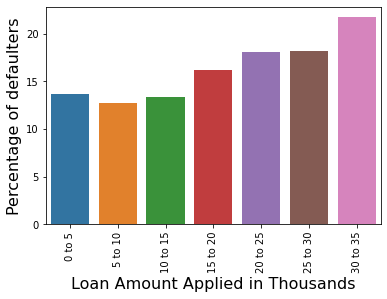

In [18]:
##Loan amount buckets for x - axis
loan_amnt = pd.cut(df_loan['loan_amnt'],bins=7, duplicates='drop')
print(type(loan_amnt))


##Remove Duplicates in buckets
loan_amnt = loan_amnt.unique()



#### Plotting the percentage of defaulters with respect to loan amount
y = percentChargedOffInBucket(df_loan,'loan_amnt',7,"numeric")
x = generate_xAxis(sorted(getIntervalList(loan_amnt)),1000)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Loan Amount Applied in Thousands",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b>

As the loan amount applied increases the chances of the customer being charged off increases , hence we need to be cautious before granting the loan. The person has to bee screened carefully before approving the loan

<class 'pandas.core.series.Series'>
[5.401, 9.254] 
 Fully Paid     9385
Charged Off     600
Current          42
Name: loan_status, dtype: int64
[9.254, 13.088] 
 Fully Paid     12393
Charged Off     1856
Current          383
Name: loan_status, dtype: int64
[13.088, 16.922] 
 Fully Paid     8704
Charged Off    2066
Current         338
Name: loan_status, dtype: int64
[16.922, 20.756] 
 Fully Paid     2184
Charged Off     907
Current         306
Name: loan_status, dtype: int64
[20.756, 24.59] 
 Fully Paid     284
Charged Off    198
Current         71
Name: loan_status, dtype: int64


Text(0, 0.5, 'Percentage of defaulters')

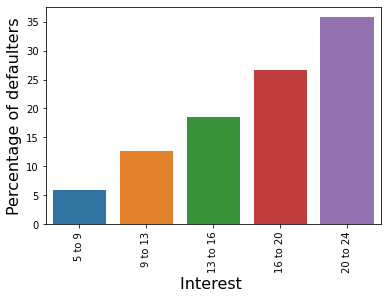

In [19]:
##interest rate buckets for x - axis
int_rate = pd.cut(df_loan['int_rate'],bins=5, duplicates='drop')
print(type(int_rate))


##Remove Duplicates in buckets
int_rate = int_rate.unique()

y = percentChargedOffInBucket(df_loan,'int_rate',5,"numeric")
x = generate_xAxis(sorted(getIntervalList(int_rate)),1)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Interest ",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b> <br/>

 As the interest rate increases the chances for the loan applicant to repay the loan decreases and as a result the chances of him/her being a defaulter increases

## Lets view the distribution of open_acc with loan status 

<ol><li>More the number of credit lines more the chnaces of default</li>
    <li> The person is supposed to have lower credit line so that he/she is not a defaulter</li>
</ol>



### We will do box plot and distribution plot

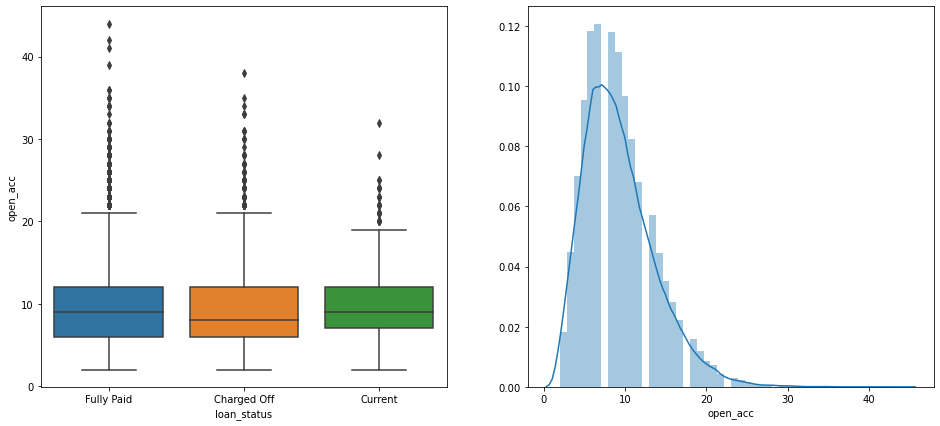

In [20]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
boxplot = sns.boxplot(data= df_loan,x="loan_status",y='open_acc')
plt.subplot(1,2,2)
distplot = sns.distplot(df_loan["open_acc"])

Let us observe the percentage of defaulters with respect to accounts

1. Lets have 8 buckets of size 5 each - x-axis
2. Let the y axis be the percentage of defaulters present in the bucket
3. As the number of open credit lines is 44 we will divide the buckets of 11 each

<class 'pandas.core.series.Series'>
[1.958, 12.5] 
 Fully Paid     26128
Charged Off     4486
Current          870
Name: loan_status, dtype: int64
[12.5, 23.0] 
 Fully Paid     6607
Charged Off    1091
Current         260
Name: loan_status, dtype: int64
[23.0, 33.5] 
 Fully Paid     202
Charged Off     47
Current         10
Name: loan_status, dtype: int64
[33.5, 44.0] 
 Fully Paid     13
Charged Off     3
Name: loan_status, dtype: int64


Text(0, 0.5, 'Percentage of defaulters')

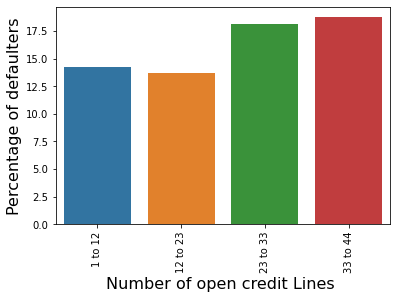

In [21]:
##Credit line buckets for x - axis
open_acc = pd.cut(df_loan['open_acc'],bins=4, duplicates='drop')
print(type(open_acc))

##Remove Duplicates in buckets
open_acc = open_acc.unique()

y = percentChargedOffInBucket(df_loan,'open_acc',4,"numeric")
x= generate_xAxis(sorted(getIntervalList(open_acc)),1)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Number of open credit Lines ",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b> <br/>
We can observe here that the maximum percentage of defaulters are present in the range of 33 to  44 and the second highest percentage of defaulters are present between 23 and 33 open credit lines.<br>
Hence we can conclude that more the number of credit lines more the chances of person being defaulter

### Lets observe the behaviour of the defaulters based on the Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

#### Lets clean the data first so that column contains only numeric values

In [22]:
df_loan['revol_util'] = df_loan['revol_util'].apply(lambda x: str(x))
df_loan['revol_util'] = df_loan['revol_util'].apply(lambda x: x.replace('%',''))
df_loan['revol_util'] = df_loan['revol_util'].apply(lambda x: float(x))
df_loan['revol_util'] = df_loan['revol_util'].fillna(df_loan['revol_util'].median())### Replace NaNs with median

### Let us plot the % of defaulters with revolving line utilization

<class 'pandas.core.arrays.categorical.Categorical'>
[-0.0999, 9.99] 
 Fully Paid     3968
Charged Off     433
Current          85
Name: loan_status, dtype: int64
[9.99, 19.98] 
 Fully Paid     2980
Charged Off     334
Current          71
Name: loan_status, dtype: int64
[19.98, 29.97] 
 Fully Paid     3299
Charged Off     416
Current         101
Name: loan_status, dtype: int64
[29.97, 39.96] 
 Fully Paid     3503
Charged Off     497
Current         119
Name: loan_status, dtype: int64
[39.96, 49.95] 
 Fully Paid     3648
Charged Off     617
Current         118
Name: loan_status, dtype: int64
[49.95, 59.94] 
 Fully Paid     3556
Charged Off     631
Current         136
Name: loan_status, dtype: int64
[59.94, 69.93] 
 Fully Paid     3446
Charged Off     664
Current         154
Name: loan_status, dtype: int64
[69.93, 79.92] 
 Fully Paid     3207
Charged Off     695
Current         134
Name: loan_status, dtype: int64
[79.92, 89.91] 
 Fully Paid     2898
Charged Off     674
Current         12

Text(0, 0.5, 'Percentage of defaulters')

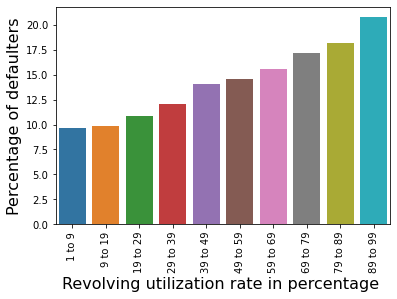

In [23]:
##Revolving utilization buckets for x - axis
revol_util = pd.cut(df_loan['revol_util'],bins=10, duplicates='drop')
print(type(open_acc))

##Remove Duplicates in buckets
revol_util = revol_util.unique()
xAxis  = sorted(getIntervalList(revol_util))
#xAxis.pop()
y = percentChargedOffInBucket(df_loan,'revol_util',10,"numeric")
x= generate_xAxis(sorted(getIntervalList(xAxis)),1)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Revolving utilization rate in percentage ",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b><br>
1. As the revolving line utilization increases the percentage of defaulters increases
2. To be on a safer side it is recomended to have revolvin utilization rate below 50%.
3. As the revolving line utilization goes beyond that the risk of the loan increases

### Now let us analyse the behavior of defaulters with respect to credit lines
 Let us plot the distribution of the revolving balance

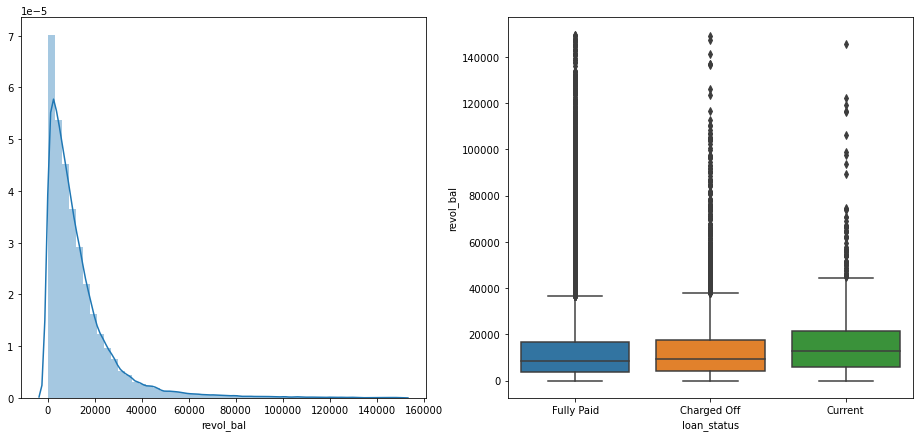

In [24]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sns.distplot(df_loan['revol_bal'])
plt.subplot(1,2,2)
sns.boxplot(data=df_loan,x="loan_status",y="revol_bal")

<class 'pandas.core.series.Series'>
[-149.588, 18698.5] 
 Fully Paid     25923
Charged Off     4362
Current          780
Name: loan_status, dtype: int64
[18698.5, 37397.0] 
 Fully Paid     5013
Charged Off     916
Current         258
Name: loan_status, dtype: int64
[37397.0, 56095.5] 
 Fully Paid     1123
Charged Off     227
Current          68
Name: loan_status, dtype: int64
[56095.5, 74794.0] 
 Fully Paid     434
Charged Off     58
Current         24
Name: loan_status, dtype: int64
[74794.0, 93492.5] 
 Fully Paid     221
Charged Off     34
Current          1
Name: loan_status, dtype: int64
[93492.5, 112191.0] 
 Fully Paid     122
Charged Off     20
Current          4
Name: loan_status, dtype: int64
[112191.0, 130889.5] 
 Fully Paid     74
Charged Off     4
Current         4
Name: loan_status, dtype: int64
[130889.5, 149588.0] 
 Fully Paid     40
Charged Off     6
Current         1
Name: loan_status, dtype: int64


Text(0, 0.5, 'Percentage of defaulters')

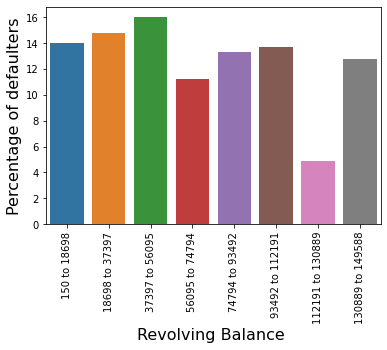

In [25]:
##Credit line buckets for x - axis
revol_bal = pd.cut(df_loan['revol_bal'],bins=8, duplicates='drop')
print(type(revol_bal))

##Remove Duplicates in buckets
revol_bal = revol_bal.unique()

y = percentChargedOffInBucket(df_loan,'revol_bal',8,"numeric")
x= generate_xAxis(sorted(getIntervalList(revol_bal)),1)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Revolving Balance ",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

## Now let us examine the % of defaulters with respect to the loan purpose

1. Let us obeseve which loan purposes is vulnerable to defaulters
2. The loan purposes where defaulter percentage is higher have to be examined carefully before giving loans


<class 'pandas.core.series.Series'>


Text(0, 0.5, 'Percentage of defaulters')

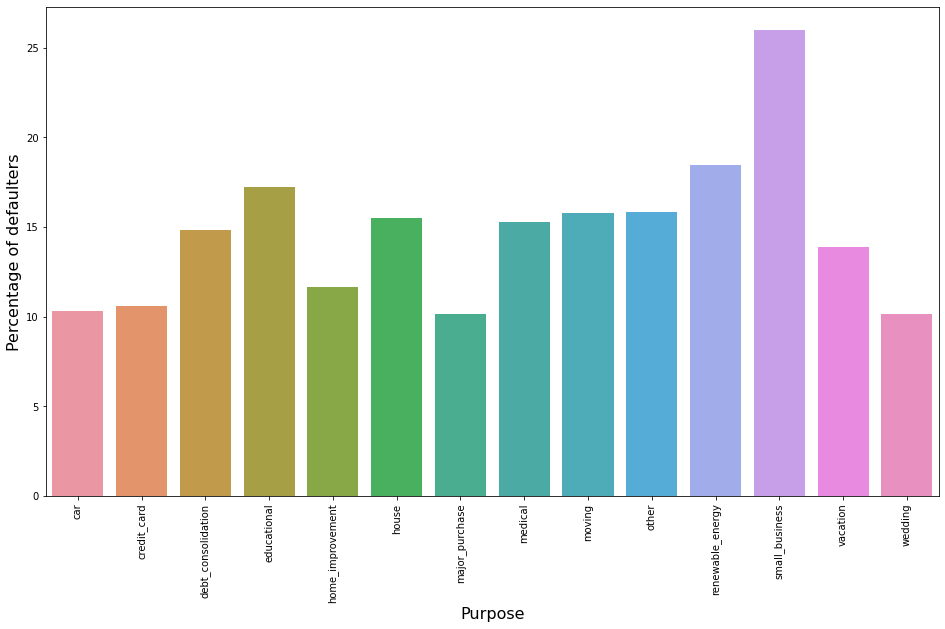

In [26]:
##Credit line buckets for x - axis
revol_bal = pd.cut(df_loan['revol_bal'],bins=8, duplicates='drop')
print(type(revol_bal))

##Remove Duplicates in buckets
revol_bal = revol_bal.unique()

y = percentChargedOffInBucket(df_loan,'purpose',14,"categorical")
x= sorted(df_loan['purpose'].unique())
len(x)
plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Purpose",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<u>Obeservations:</u><br/>
The loans which were applied for small business seems to be most dangerous since the % of defaulters were high.
This could be because of unvialble business model

### Lets observe the influence of Home ownership on the loan status


1. X axis will have the data of the Home ownership
2. Y axis will have the percentage of defaulters


Text(0, 0.5, 'Percentage of defaulters')

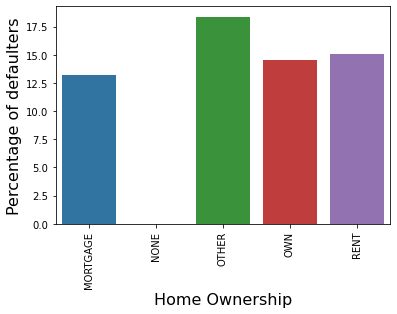

In [27]:

##Remove Duplicates in buckets
#home_ownership = home_ownership.unique()

y = percentChargedOffInBucket(df_loan,'home_ownership',5,"categorical")
x= sorted(df_loan['home_ownership'].unique())
len(x)
#plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Home Ownership",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)


### Obeservation

1. The people who have home ownership as others have more % of defaulters
2. The term others seem be be suspicious
3. These people might have incorrectly shown their address while applying for the loan 

## Lets check the distribution of years of employment

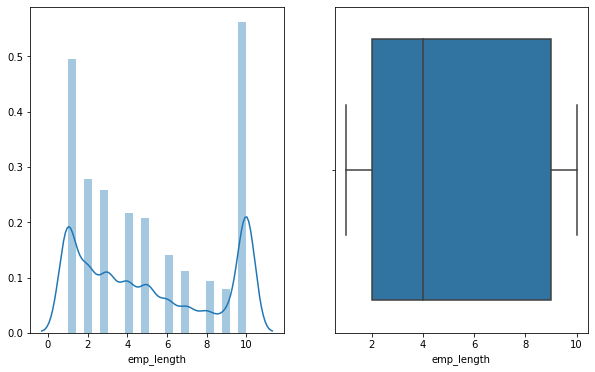

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(df_loan['emp_length'])
plt.subplot(1,2,2)
sns.boxplot(df_loan['emp_length'])

### Lets analyse the influence of years of employment om the loan status

lets plot the percentage of defaulters with respect to employment years 

<ipython-input-17-d88e9addc4fd>:75: RuntimeWarning: invalid value encountered in longlong_scalars
  percenageOfChargedOff = 100 * totalDefaultersInBucket/bucketSize


Text(0, 0.5, 'Percentage of defaulters')

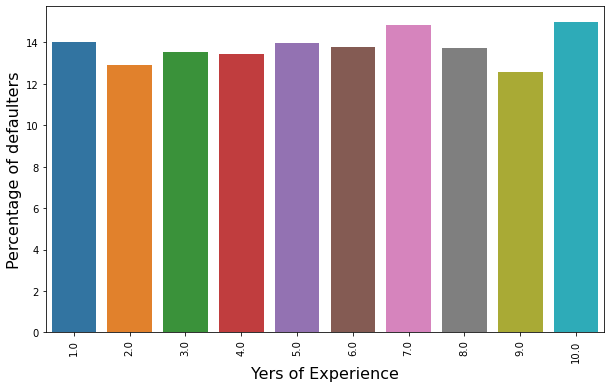

In [29]:
y = percentChargedOffInBucket(df_loan,'emp_length',10,"categorical")
x= sorted(df_loan['emp_length'].unique())
len(x)
plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Yers of Experience",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

In [30]:
df_loan['annual_inc'].max()

6000000.0

## Lets examine the influence of annual income on the defaulters



<class 'pandas.core.series.Series'>
[-1996.0, 203866.667] 
 Fully Paid     32461
Charged Off     5570
Current         1124
Name: loan_status, dtype: int64
[203866.667, 403733.333] 
 Fully Paid     411
Charged Off     45
Current         14
Name: loan_status, dtype: int64
[403733.333, 603600.0] 
 Fully Paid     37
Charged Off     5
Current         1
Name: loan_status, dtype: int64
[603600.0, 803466.667] 
 Fully Paid     21
Charged Off     5
Current         1
Name: loan_status, dtype: int64
[803466.667, 1003333.333] 
 Fully Paid     7
Charged Off    1
Name: loan_status, dtype: int64
[1003333.333, 1203200.0] 
 Fully Paid    6
Name: loan_status, dtype: int64
[1203200.0, 1403066.667] 
 Charged Off    1
Fully Paid     1
Name: loan_status, dtype: int64
[1403066.667, 1602933.333] 
 Fully Paid    1
Name: loan_status, dtype: int64
[1602933.333, 1802800.0] 
 Fully Paid    1
Name: loan_status, dtype: int64
[1802800.0, 2002666.667] 
 Fully Paid    1
Name: loan_status, dtype: int64
[2002666.667, 2202

Text(0, 0.5, 'Percentage of defaulters')

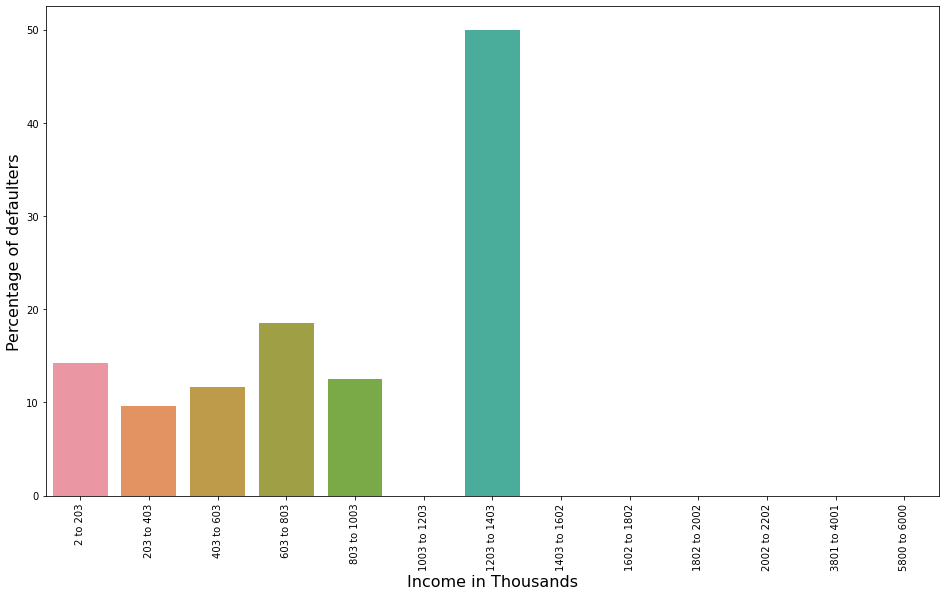

In [31]:
##Annual income bucktes
annual_inc = pd.cut(df_loan['annual_inc'],bins=30)
print(type(annual_inc))


##Remove Duplicates in buckets
annual_inc = annual_inc.unique()



#### Plotting the percentage of defaulters with respect to loan amount
y = percentChargedOffInBucket(df_loan,'annual_inc',30,"numeric")
x = generate_xAxis(sorted(getIntervalList(annual_inc)),1000)
plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Income in Thousands",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

In [32]:
df_loan[(df_loan['annual_inc']>=1203000) & (df_loan['annual_inc']<=1403000)].loan_status.value_counts()

Charged Off    1
Fully Paid     1
Name: loan_status, dtype: int64

<b><u>Observations:</u></b><br>
1. As per the observation the chances of a person defaulting increases with increase in annual income

2. The bucket of income between 12,03,000 to 14,03,000 have two people once with one of them is defaulter and other is not a defaulter, hence the percentage of default becomes 50% { 1*100/(1+1) } 

3. Therefore we cannot directly conclude that people with High income are defaulters

4. The ratio of loan applied to annual income would be ideal for further analysis, which we will do in next steps 

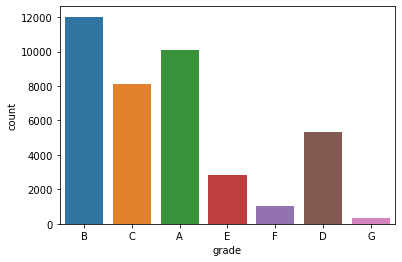

In [33]:

sns.countplot(df_loan['grade'])


## Lets examine the behavior of the the defaulters with respect to the past derogatory records.

#### If a person has a derogatory record. He/She is considered to have a bad image 

Text(0, 0.5, 'Percentage of defaulters')

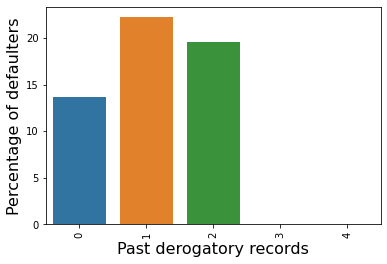

In [34]:
## Public record of bankrupties bucket
y = percentChargedOffInBucket(df_loan,'pub_rec',5,"categorical")
x= sorted(df_loan['pub_rec'].unique())
len(x)
#plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Past derogatory records",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b>Observations :</b> <br/>

1. If the person has a past derogatory record. The chances of him/her being defaulter increases

## Let us compare the results with public bankrupties 

#### We will check the past records of the customers


<ipython-input-17-d88e9addc4fd>:75: RuntimeWarning: invalid value encountered in longlong_scalars
  percenageOfChargedOff = 100 * totalDefaultersInBucket/bucketSize


Text(0, 0.5, 'Percentage of defaulters')

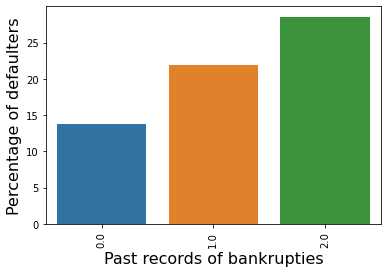

In [35]:
## Public record of bankrupties bucket
y = percentChargedOffInBucket(df_loan,'pub_rec_bankruptcies',7,"categorical")
x= sorted(df_loan['pub_rec_bankruptcies'].unique())
len(x)
#plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Past records of bankrupties",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b><br>
More the number of past bankrupties the chances of the person being defaulter increases

lets examine the distribution of delinq_2yrs 

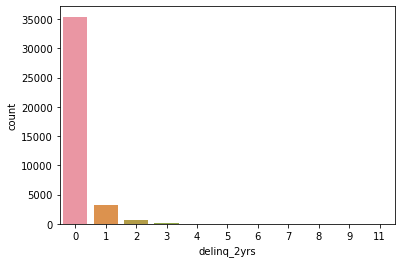

In [36]:
sns.countplot(df_loan['delinq_2yrs'],)

### Lets find the defaulters by the past delequency records

Text(0, 0.5, 'Percentage of defaulters')

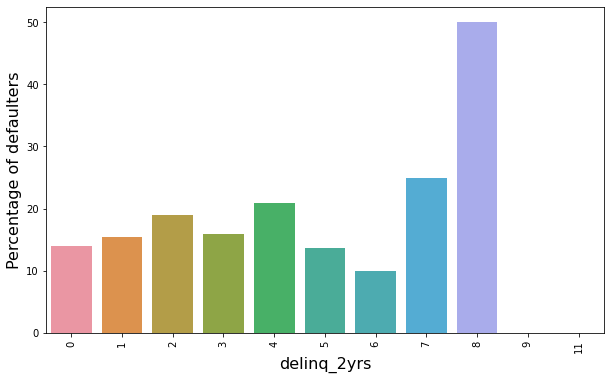

In [37]:
y = percentChargedOffInBucket(df_loan,'delinq_2yrs',11,"categorical")
x= sorted(df_loan['delinq_2yrs'].unique())
len(x)
plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("delinq_2yrs",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

## Lets observe the distribution of the grades in the dataset

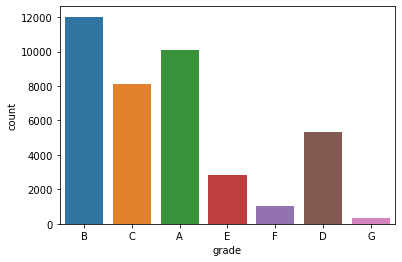

In [38]:
#plt.subplot(1,2,1)

sns.countplot(df_loan['grade'])


## Most of the loans approved belongs to grade A, B & C

Text(0, 0.5, 'Percentage of defaulters')

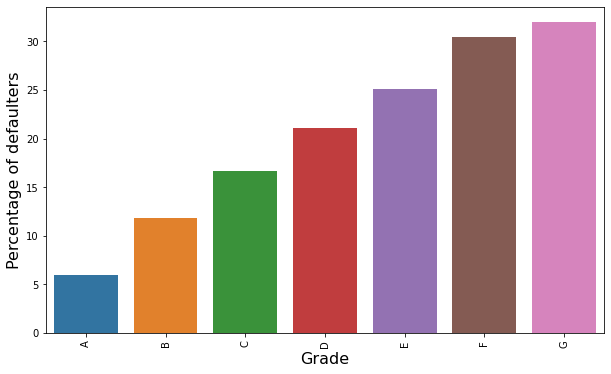

In [39]:
y = percentChargedOffInBucket(df_loan,'grade',7,"categorical")
x= sorted(df_loan['grade'].unique())
len(x)
plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Grade",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observations:</u></b>
<br> Grades D,E,F,G have high chances of charged off customers

In [40]:
df_loan['loan_to_income'] = 100*df_loan['loan_amnt']/df_loan['annual_inc']

<class 'pandas.core.series.Series'>
[-0.00397, 8.371] 
 Fully Paid     6759
Charged Off     864
Current          90
Name: loan_status, dtype: int64
[8.371, 16.663] 
 Fully Paid     10554
Charged Off     1397
Current          217
Name: loan_status, dtype: int64
[16.663, 24.955] 
 Fully Paid     7790
Charged Off    1300
Current         283
Name: loan_status, dtype: int64
[24.955, 33.247] 
 Fully Paid     4269
Charged Off     956
Current         227
Name: loan_status, dtype: int64
[33.247, 41.539] 
 Fully Paid     2244
Charged Off     594
Current         164
Name: loan_status, dtype: int64
[41.539, 49.832] 
 Fully Paid     869
Charged Off    301
Current         84
Name: loan_status, dtype: int64
[49.832, 58.124] 
 Fully Paid     357
Charged Off    176
Current         68
Name: loan_status, dtype: int64
[58.124, 66.416] 
 Fully Paid     78
Charged Off    28
Current         6
Name: loan_status, dtype: int64
[66.416, 74.708] 
 Fully Paid     23
Charged Off     8
Name: loan_status, dtype: int6

Text(0, 0.5, 'Percentage of defaulters')

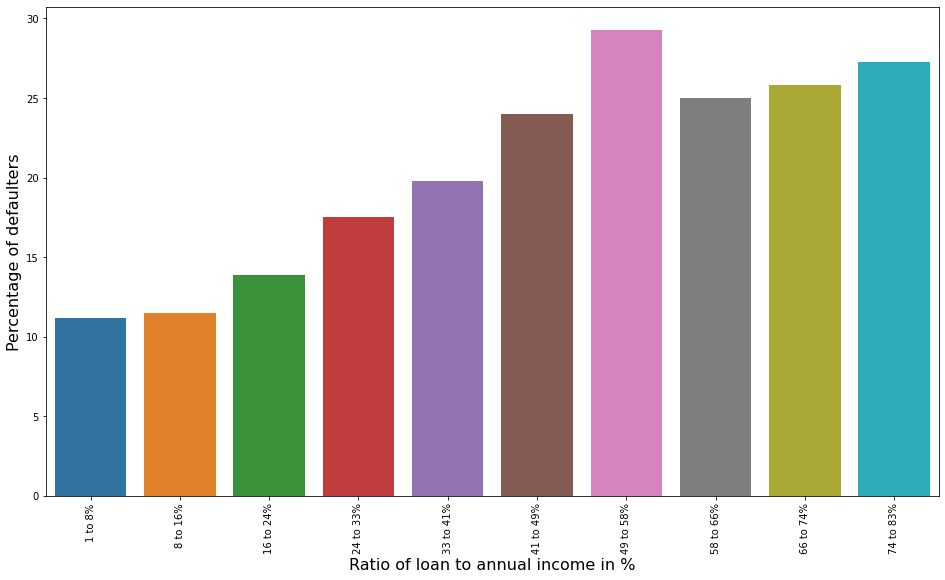

In [41]:
##Annual income bucktes
annual_inc = pd.cut(df_loan['loan_to_income'],bins=10)
print(type(annual_inc))


##Remove Duplicates in buckets
annual_inc = annual_inc.unique()



#### Plotting the percentage of defaulters with respect to loan amount
y = percentChargedOffInBucket(df_loan,'loan_to_income',10,"numeric")
x = generate_xAxis(sorted(getIntervalList(annual_inc)),1)
x = map(lambda a: a+'%',x)
x = list(x)
plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Ratio of loan to annual income in %",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

### Observations

1. As the <b>ratio of loan taken to annual income increases</b> the chances of person being charged off increases.
2. It is always desirable to have annual income higher than the loan applied.
3. Hence the <b>ratio of the loan applied to the annual income</b> has to be low 
4. Our observation indicates that when the loan is over 40% of the annual income. There is a higher chance of default

### Lets observe the distribution of revolving balance to income 

Text(0, 0.5, 'Annual income')

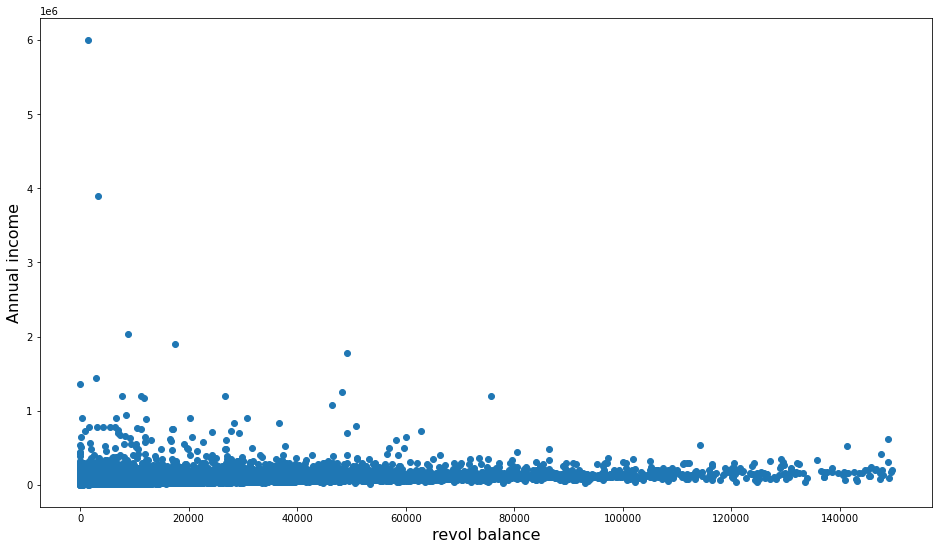

In [42]:
plt.figure(figsize=(16,9))
plt.scatter(df_loan['revol_bal'],df_loan['annual_inc'])
plt.xlabel("revol balance",fontsize=16)
plt.ylabel("Annual income",fontsize=16)

<b><u>Observations:</u></b>
We can see that there are customers with high ratio of <b>Revolving balance to annual income</b> These customers are dangerous.
Higher the ratio more the chances of defaulting

In [43]:
df_loan['revol_2_inc'] = 100*df_loan['revol_bal']/df_loan['annual_inc']

### Lets plot the influence of the above ratio derived column on Defaulters

<class 'pandas.core.series.Series'>
[-0.312, 15.582] 
 Fully Paid     16715
Charged Off     2483
Current          449
Name: loan_status, dtype: int64
[15.582, 31.165] 
 Fully Paid     9592
Charged Off    1719
Current         372
Name: loan_status, dtype: int64
[31.165, 46.747] 
 Fully Paid     4078
Charged Off     853
Current         218
Name: loan_status, dtype: int64
[46.747, 62.329] 
 Fully Paid     1519
Charged Off     343
Current          65
Name: loan_status, dtype: int64
[62.329, 77.912] 
 Fully Paid     589
Charged Off    132
Current         21
Name: loan_status, dtype: int64
[77.912, 93.494] 
 Fully Paid     285
Charged Off     63
Current          8
Name: loan_status, dtype: int64
[93.494, 109.077] 
 Fully Paid     87
Charged Off    15
Current         5
Name: loan_status, dtype: int64
[109.077, 124.659] 
 Fully Paid     33
Charged Off     5
Current         2
Name: loan_status, dtype: int64
[124.659, 140.241] 
 Fully Paid     18
Charged Off     7
Name: loan_status, dtype: int64

Text(0, 0.5, 'Percentage of defaulters')

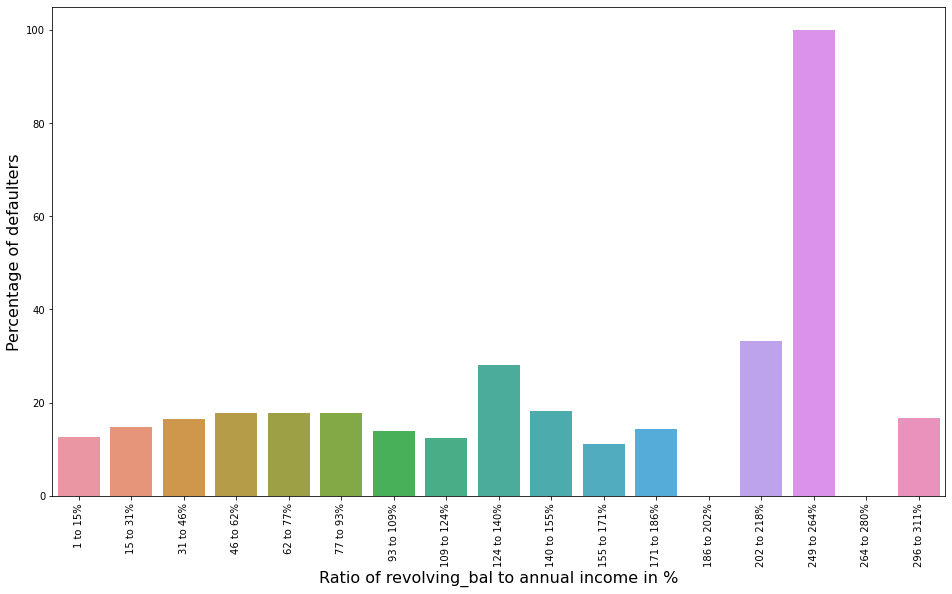

In [44]:
annual_inc = pd.cut(df_loan['revol_2_inc'],bins=20)
print(type(annual_inc))


##Remove Duplicates in buckets
annual_inc = annual_inc.unique()



#### Plotting the percentage of defaulters with respect to loan amount
y = percentChargedOffInBucket(df_loan,'revol_2_inc',20,"numeric")
x = generate_xAxis(sorted(getIntervalList(annual_inc)),1)
x = map(lambda a: a+'%',x)
x = list(x)
plt.figure(figsize=(16,9))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Ratio of revolving_bal to annual income in %",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

<b><u>Observation</u></b><br />
<ul>
<li>As the ratio between revolving balance and the annual income increases the chances of default increases</li>
    <li>When the <b>revolving balance is >= (1.24*Annual Income)</b> Percentage of defaulters increase</li>
    <li> It is recommended that the revolving balance has to be lesser than the annual income i.e <b>the ratio should be less than 100%</b>while granting loans</li>
    <li>Any Loan with the Ratio greater than 100% needs to be declined to minimize the risks</li>
</ul>

### Lets begin with the bivariate analysis

#### We would be examining the behavior of one variable to other

Text(0, 0.5, 'Interest Rate')

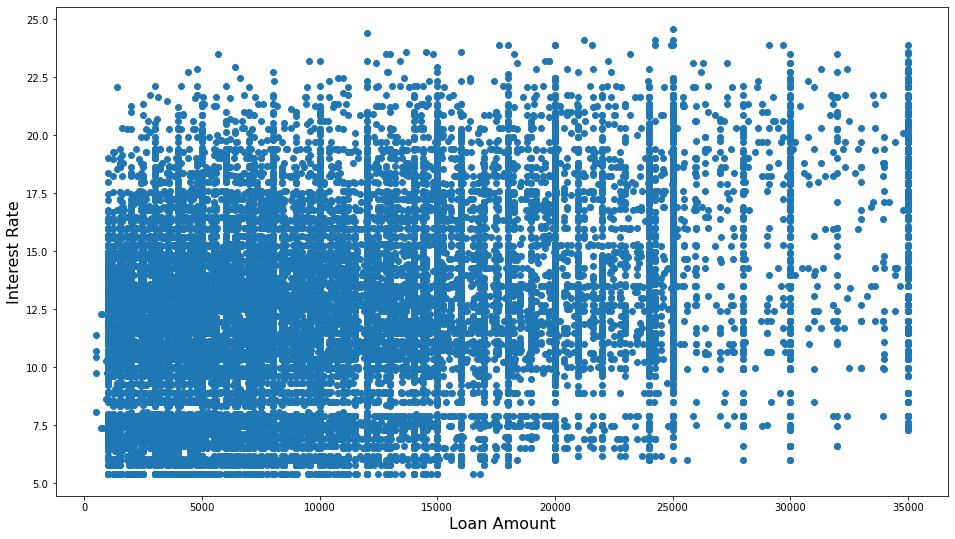

In [45]:
plt.figure(figsize=(16,9))
plt.scatter(df_loan['loan_amnt'],df_loan['int_rate'])
plt.xlabel("Loan Amount",fontsize=16)
plt.ylabel("Interest Rate",fontsize=16)

In [46]:
df_loan.corr().loc["loan_amnt","int_rate"]

0.30941527364505594

<b>Observation</b>
<br>As the loan amount increases the interest rate increases. We can observe the same by examining the corelation function which comes to 0.3

#### Let us examine the plot of loan amount the anual income

Text(0, 0.5, 'Annual Income')

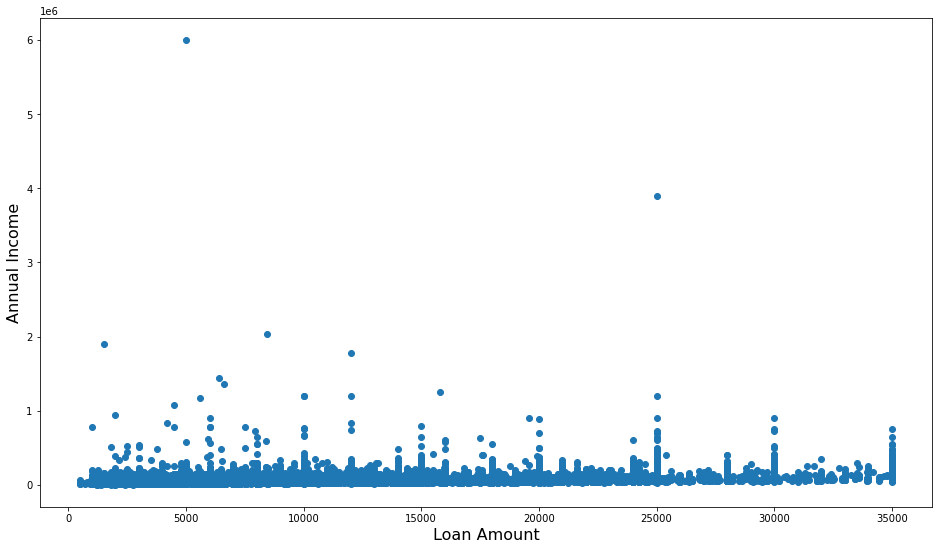

In [47]:
plt.figure(figsize=(16,9))
plt.scatter(df_loan['loan_amnt'],df_loan['annual_inc'])
plt.xlabel("Loan Amount",fontsize=16)
plt.ylabel("Annual Income",fontsize=16)

In [48]:
df_loan.corr().loc["loan_amnt","annual_inc"]

0.2711485508165311

#### Observation
1. As the annual income increases the loan amount applied also increases. we can observe that the corelation is positive here

### Let us examine the influence of the grade on the loan amount

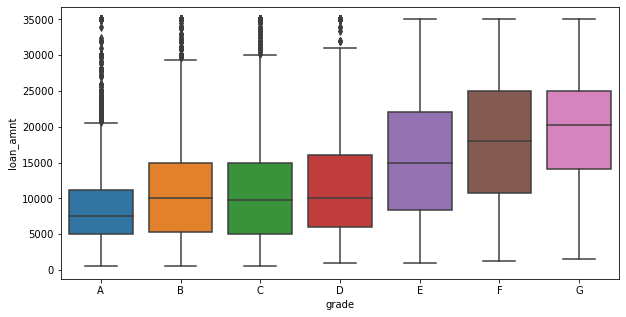

In [49]:
#grade_2_loan_amnt = df_loan.groupby(by='grade').count()
plt.figure(figsize=(10,5))
sns.boxplot(x=df_loan['grade'],y=df_loan['loan_amnt'],order=sorted(df_loan['grade'].unique()))

#### Observations:
1. From Grades E onwards the the loan given increases.
2. Due to acceptance of loans with high amount the probability of the person being charged off increases

### Lets examine the plot of the revol_utol and the interest rate

Text(0, 0.5, 'Interest rate')

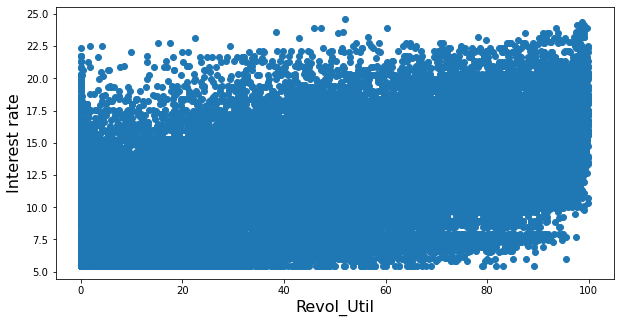

In [50]:
plt.figure(figsize=(10,5))
plt.scatter(df_loan['revol_util'],df_loan['int_rate'])
plt.xlabel("Revol_Util",fontsize=16)
plt.ylabel("Interest rate",fontsize=16)

In [51]:
df_loan['revol_util'].corr(df_loan['int_rate'])

0.46677253361681725

#### Observation:

1. As the revol_util rate increases the interest rate charged for it also increases. We can conclude the same as the corelation observed is positive

## Lets examine the behavior of loan grade on the interest rate 

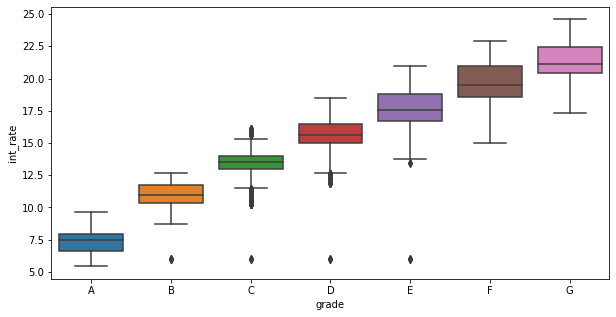

In [52]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_loan['grade'],y=df_loan['int_rate'] , order=sorted(df_loan['grade'].unique()))

#### Observation:
1. As the Grade increases form A,B,C and so on the interest chargeo in it also increases

### Lets compare the behavior of address verification status on the loan amount

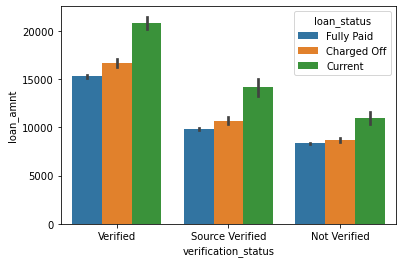

In [53]:
sns.barplot(x='verification_status', y='loan_amnt', hue="loan_status", data=df_loan)


<b>Observations</b>


1. we can see higher loan amount present in the verified bucket
2. Higher loan amount gets approved in verified bucket

#### Now lets see the percentage of defaulters as per home verification status

Text(0, 0.5, 'Percentage of defaulters')

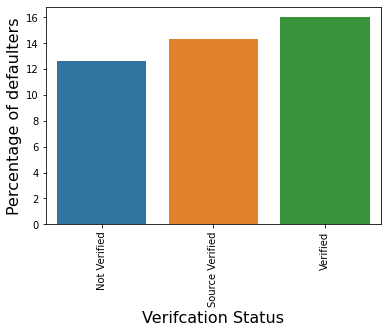

In [54]:
y = percentChargedOffInBucket(df_loan,'verification_status',3,"categorical")
x= sorted(df_loan['verification_status'].unique())
len(x)
#plt.figure(figsize=(10,6))
plot = sns.barplot(x=x,y=y)
plt.xticks(rotation = 90)
plt.xlabel("Verifcation Status",fontsize=16)
plt.ylabel("Percentage of defaulters",fontsize=16)

#### Observation:
1. Higher loan amounts are Verified mostly.
2. As we know that larger loans are less in number, but see a higher charge off(default) rate
3. As we can compare this graph with the previous observation we can conclude that customers with verification as verified has larger percenatge of defaulters. This is because high amounts of loan gets approved under verified status.


## Now let us examine the behaviour of defaulters with the term an purpose of the loan

### let us plot the bar graph

<Figure size 2160x1152 with 0 Axes>

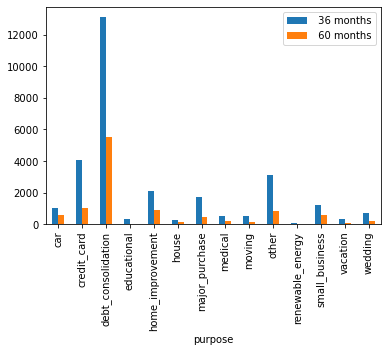

In [55]:




plt.figure(figsize=(30,16))
df_derived = df_loan.groupby(by=['purpose','term']).count()['loan_status'].unstack(1).plot.bar()
plt.legend( loc = 'upper right')




#### We can see here that most of the loans are applied under debt consolidation followed by credit card

### Lets plot tthe same in different way

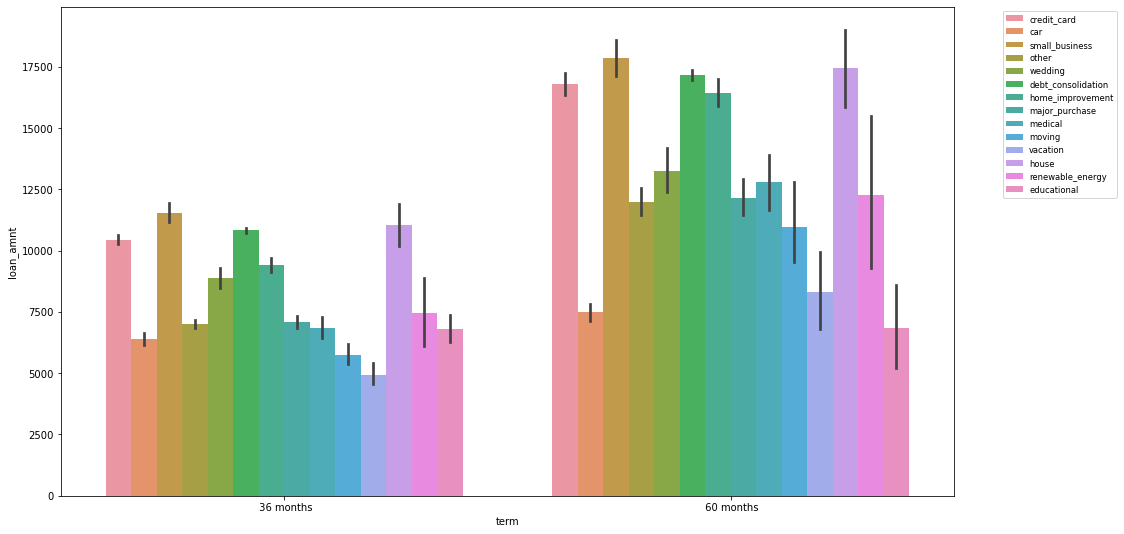

In [56]:
from matplotlib.font_manager import FontProperties
plt.figure(figsize=(16,9))
sns.barplot(data=df_loan,y='loan_amnt',x='term',hue='purpose')

fontP = FontProperties()
fontP.set_size('small')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

## Lets plot the summarry of the influence of one variable to another using seaborn heatmap



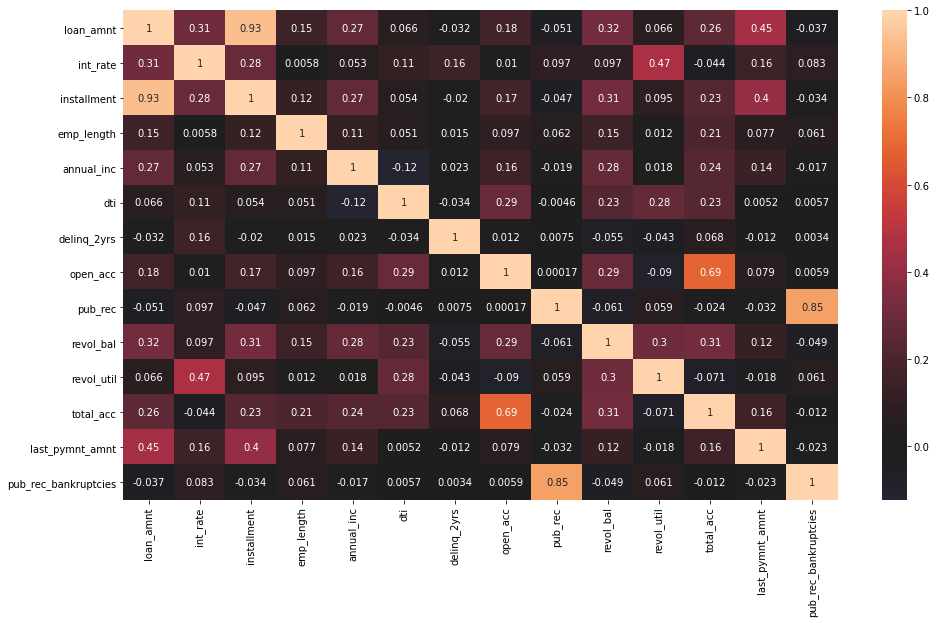

In [57]:
##Key columns are the target columns where we are going to run the summary report

key_columns = ['loan_amnt', 'int_rate', 'installment',
       'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies']
hMap = df_loan.loc[:,key_columns].corr()
plt.figure(figsize=(16,9))
sns.heatmap(hMap,center=0.0,annot=True)